# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, you will use your trained model to generate captions for images in the test dataset.

This notebook **will be graded**.  

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Get Data Loader for Test Dataset 
- [Step 2](#step2): Load Trained Models
- [Step 3](#step3): Finish the Sampler
- [Step 4](#step4): Clean up Captions
- [Step 5](#step5): Generate Predictions!

<a id='step1'></a>
## Step 1: Get Data Loader for Test Dataset

Before running the code cell below, define the transform in `transform_test` that you would like to use to pre-process the test images.  

Make sure that the transform that you define here agrees with the transform that you used to pre-process the training images (in **2_Training.ipynb**).  For instance, if you normalized the training images, you should also apply the same normalization procedure to the test images.

In [28]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


Run the code cell below to visualize an example test image, before pre-processing is applied.

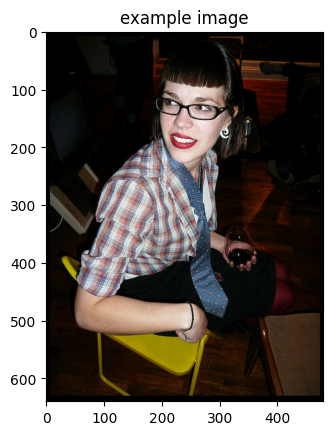

In [29]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

<a id='step2'></a>
## Step 2: Load Trained Models

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).  Run this code cell before continuing.

In [30]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Before running the code cell below, complete the following tasks.

### Task #1

In the next code cell, you will load the trained encoder and decoder from the previous notebook (**2_Training.ipynb**).  To accomplish this, you must specify the names of the saved encoder and decoder files in the `models/` folder (e.g., these names should be `encoder-5.pkl` and `decoder-5.pkl`, if you trained the model for 5 epochs and saved the weights after each epoch).  

### Task #2

Plug in both the embedding size and the size of the hidden layer of the decoder corresponding to the selected pickle file in `decoder_file`.

In [31]:
# Watch for any changes in model.py, and re-load it automatically.
%load_ext autoreload
%autoreload 2

import os
import torch
from model_v1 import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
encoder_file = "encoder-3.pkl" 
decoder_file = "decoder-3.pkl"

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 256
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.

#encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
#decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file), map_location=torch.device('cpu')))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file), map_location=torch.device('cpu')))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/kuubi3d/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kuubi3d/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DecoderRNN(
  (embed): Embedding(9947, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9947, bias=True)
)

<a id='step3'></a>
## Step 3: Finish the Sampler

Before executing the next code cell, you must write the `sample` method in the `DecoderRNN` class in **model.py**.  This method should accept as input a PyTorch tensor `features` containing the embedded input features corresponding to a single image.

It should return as output a Python list `output`, indicating the predicted sentence.  `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence.  The correspondence between integers and tokens can be explored by examining either `data_loader.dataset.vocab.word2idx` (or `data_loader.dataset.vocab.idx2word`).

After implementing the `sample` method, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.  Do **not** modify the code in the cell below. 

In [41]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
# output = decoder.sample(features)
#output = decoder.beam_search(features, k=3, max_len=20, states=None)
start_token = data_loader.dataset.vocab.word2idx['<start>']  # Start of sentence token
end_token = data_loader.dataset.vocab.word2idx['<end>']  # End of sentence token

print(start_token)
print(end_token)

output = decoder.beam_search(features, start_token, end_token, k=3, max_len=20)
print('example output:', output)
#output = decoder.sample(features, k=3, max_len=20)
#print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

0
1
top scores tensor([[10.3373,  8.4977,  7.5677]], device='cuda:0', grad_fn=<TopkBackward0>) tensor([[ 3, 50, 32]], device='cuda:0')
new caption tensor([0, 3], device='cuda:0')
new caption tensor([ 0, 50], device='cuda:0')
new caption tensor([ 0, 32], device='cuda:0')
top scores tensor([[9.1629, 8.7175, 8.0994]], device='cuda:0', grad_fn=<TopkBackward0>) tensor([[ 80, 330,  91]], device='cuda:0')
new caption tensor([ 0,  3, 80], device='cuda:0')
new caption tensor([  0,   3, 330], device='cuda:0')
new caption tensor([ 0,  3, 91], device='cuda:0')
top scores tensor([[8.0586, 7.9580, 7.6406]], device='cuda:0', grad_fn=<TopkBackward0>) tensor([[ 51, 454, 107]], device='cuda:0')
new caption tensor([ 0, 50, 51], device='cuda:0')
new caption tensor([  0,  50, 454], device='cuda:0')
new caption tensor([  0,  50, 107], device='cuda:0')
top scores tensor([[6.4566, 6.1352, 5.8982]], device='cuda:0', grad_fn=<TopkBackward0>) tensor([[ 91,  50, 169]], device='cuda:0')
new caption tensor([ 0, 32,

<a id='step4'></a>
## Step 4: Clean up the Captions

In the code cell below, complete the `clean_sentence` function.  It should take a list of integers (corresponding to the variable `output` in **Step 3**) as input and return the corresponding predicted sentence (as a single Python string). 

In [42]:
# TODO #4: Complete the function.
def clean_sentence(output):
    sentence = ''
    for i in output:
        word = data_loader.dataset.vocab.idx2word[i]
        if i == 0:
            continue
        if i == 1:
            break
        if i == 18:
            sentence = sentence + word
        else:
            sentence = sentence + ' ' + word
    
    return sentence.strip()

After completing the `clean_sentence` function above, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.

In [43]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: a woman standing in a field with a dog.


<a id='step5'></a>
## Step 5: Generate Predictions!

In the code cell below, we have written a function (`get_prediction`) that you can use to use to loop over images in the test dataset and print your model's predicted caption.

In [44]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.beam_search(features, start_token, end_token, k=5, max_len=20) 
    #output = decoder.sample(features, max_len=20, k=3) 
    sentence = clean_sentence(output)
    print(sentence)

Run the code cell below (multiple times, if you like!) to test how this function works.

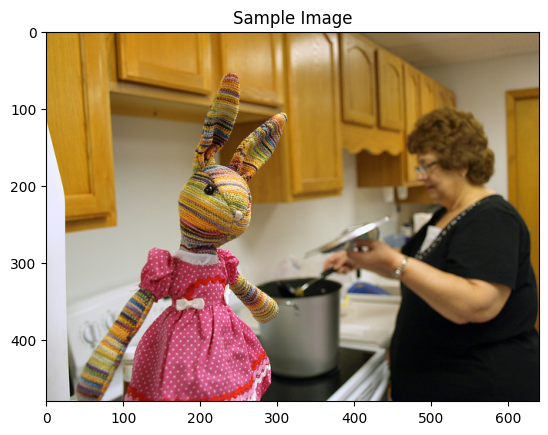

outputs tensor([[21.6045,  0.5496,  1.5587,  ..., -3.2342, -5.2102, -2.1975]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([0], device='cuda:0')
outputs tensor([[-1.8215, -2.0500,  4.9643,  ..., -3.7155, -5.4146, -5.1826]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([3], device='cuda:0')
outputs tensor([[-2.9104, -2.4719,  6.1874,  ..., -5.9518, -0.6901, -5.6686]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([59], device='cuda:0')
outputs tensor([[-2.6715, -2.5622,  4.8984,  ..., -7.4017, -4.3406, -6.4199]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([92], device='cuda:0')
outputs tensor([[-5.6939,  2.0623,  4.0006,  ..., -6.7409, -7.9971, -4.4151]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([130], device='cuda:0')
outputs tensor([[-5.5998,  1.2753,  5.7172,  ..., -4.8968, -6.9287, -1.2643]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([360], dev

In [45]:
get_prediction()

As the last task in this project, you will loop over the images until you find four image-caption pairs of interest:
- Two should include image-caption pairs that show instances when the model performed well.
- Two should highlight image-caption pairs that highlight instances where the model did not perform well.

Use the four code cells below to complete this task.

### The model performed well!

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively accurate captions.

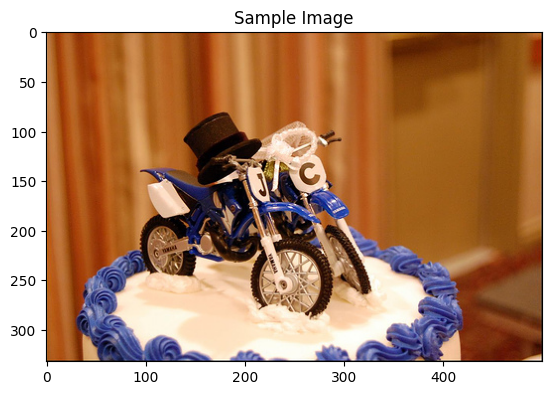

outputs tensor([[18.5783,  1.1043,  0.9964,  ..., -4.6026, -6.1325, -4.9266]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([0], device='cuda:0')
outputs tensor([[-2.1003, -2.8219,  4.4555,  ..., -5.8333, -6.7125, -7.6743]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([3], device='cuda:0')
outputs tensor([[-3.7814, -3.3299,  5.8946,  ..., -7.8918, -1.9331, -7.3111]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([900], device='cuda:0')
outputs tensor([[ -4.0989,   1.7681,   4.5779,  ..., -10.5086,  -7.7622,  -8.2667]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([131], device='cuda:0')
outputs tensor([[ -6.0892,   2.7194,   3.9535,  ..., -12.2770, -11.4992, -10.3593]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([77], device='cuda:0')
outputs tensor([[ -5.1918,  -0.8526,   4.3865,  ..., -10.4395,  -9.5920, -11.3815]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicte

In [46]:
get_prediction()

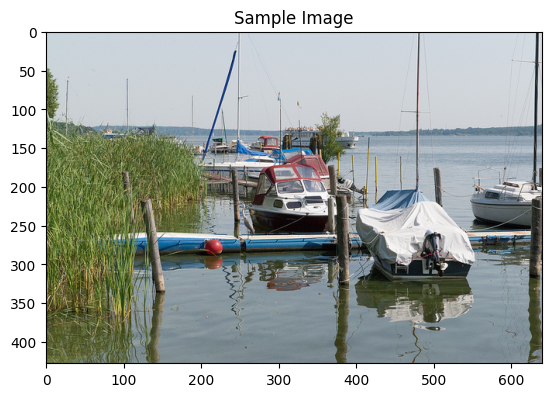

outputs tensor([[19.7810, -0.6484,  2.3158,  ..., -0.4681, -4.1822, -6.6469]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([0], device='cuda:0')
outputs tensor([[-2.4841, -2.6458,  5.0127,  ..., -3.1948, -7.4231, -9.1226]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([3], device='cuda:0')
outputs tensor([[-3.7400, -3.1210,  6.5236,  ..., -7.2877, -3.1589, -8.9379]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([277], device='cuda:0')
outputs tensor([[-2.6019,  3.0378,  4.0791,  ..., -8.8378, -9.8778, -8.2919]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([130], device='cuda:0')
outputs tensor([[-1.3378,  1.1650,  5.9170,  ..., -6.6896, -8.1500, -5.0658]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([2578], device='cuda:0')
outputs tensor([[ 2.7562,  0.2222,  4.1252,  ..., -8.3301, -8.6683, -9.9753]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([39], d

In [47]:
get_prediction()

### The model could have performed better ...

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively inaccurate captions.

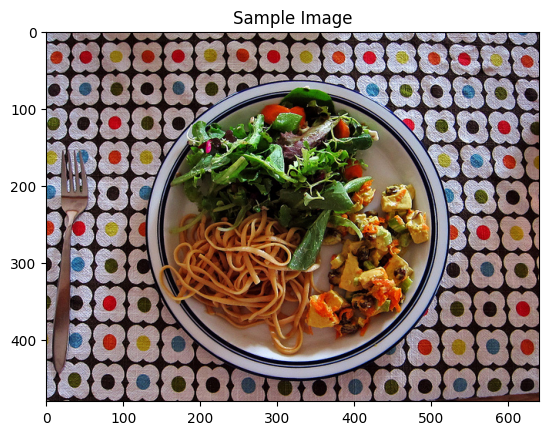

outputs tensor([[19.0575,  0.3078,  3.2343,  ..., -2.5354, -6.3678, -5.8541]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([0], device='cuda:0')
outputs tensor([[-0.1790, -2.0877,  4.3598,  ..., -3.4356, -6.9202, -7.4541]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([3], device='cuda:0')
outputs tensor([[-0.3767, -1.4116,  5.7805,  ..., -7.5966, -3.9374, -8.0337]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([822], device='cuda:0')
outputs tensor([[ -3.6633,   3.4627,   3.4860,  ...,  -8.3909, -11.5821,  -8.6253]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([13], device='cuda:0')
outputs tensor([[-1.6432, -0.9981,  6.3112,  ..., -6.1964, -6.2481, -6.7150]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([109], device='cuda:0')
outputs tensor([[  0.4026,   4.6754,   3.7586,  ...,  -7.2647, -12.1927,  -8.5974]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tens

In [48]:
get_prediction()

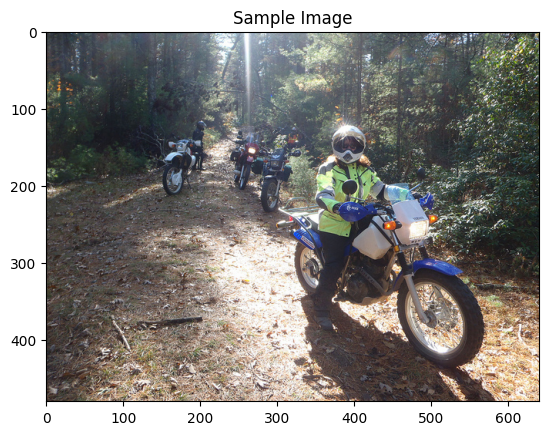

outputs tensor([[18.2091,  1.5967,  0.8806,  ..., -4.6661, -5.2774, -6.1352]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([0], device='cuda:0')
outputs tensor([[-1.4010, -1.8841,  4.3115,  ..., -5.4882, -6.6291, -7.6810]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([3], device='cuda:0')
outputs tensor([[-2.8739, -3.1471,  6.3818,  ..., -9.7698, -2.8971, -7.6236]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([80], device='cuda:0')
outputs tensor([[ -4.6208,   0.0182,   3.7418,  ...,  -9.3853, -11.0434,  -9.4422]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([13], device='cuda:0')
outputs tensor([[-5.0406, -3.9083,  5.2769,  ..., -6.9838, -5.1863, -6.5917]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([1555], device='cuda:0')
outputs tensor([[-1.8736,  2.8667,  4.9930,  ..., -8.6263, -9.5335, -8.6519]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
predicted tensor([13

In [49]:
get_prediction()